In [44]:
# load required python modules
import pandas as pd  # for processing DataFrame
import numpy as np  # for processing array
import torch  # deep learning framework
from torch import nn  # nerual network module
from torch.utils.data import Dataset, DataLoader  # prepare dataset
import matplotlib.pyplot as plt  # plotting
import time  # timer

%cd ARCA

[Errno 2] No such file or directory: 'ARCA'
/scratch/project_2002784/kareinen/SummerSchool/ARCA


In [45]:
# scale of data
DATA_MIN = 0
DATA_MAX = 31.5
ENV_MIN = -20
ENV_MAX = 800

class ChemicalDataset(Dataset):
    def __init__(self, data_file):
        self.raw_data = pd.read_pickle(data_file)  # init by load the pickle file
        self.data_min = DATA_MIN
        self.data_max = DATA_MAX

    def __len__(self):
        return len(self.raw_data)  # take number of data rows as size of dataset

    def __getitem__(self, index):
        # ########## sample data pairs #####################
        environ = np.float32(self.raw_data[index][0])  # environment params
        initial_value = np.float32(self.raw_data[index][1])  # initial chemical values
        output = np.float32(self.raw_data[index][2])  # time step outputs
        # ############## logarithmic mapping #########################
        initial_value = np.log(initial_value + 1e-6)
        output = np.log(output + 1e-6)

        environ = (environ - ENV_MIN) / (ENV_MAX - ENV_MIN)
        initial_value = (initial_value - self.data_min) / (self.data_max - self.data_min)
        output = (output - self.data_min) / (self.data_max - self.data_min)

        # pack a sample into a dictionary
        outputs = {"environ": environ, "initial_value":initial_value, "output": output}

        return outputs


def prepare_data(batch):
    """reshape data for network input"""
    env = batch['environ']  # envoriment features
    init = batch['initial_value']  # inital chemical status
    targets = batch['output']  # target future chemical status

    inputs = torch.cat([env, init], dim=1)  # concatenate features

    inputs = inputs.to(device)  # move inputs tensor to device
    targets = targets.to(device)  # move targets tensor to device

    return inputs, targets  # return feature and ground truth

In [50]:
train_dataset = ChemicalDataset("training.pk")  # load train dataset
val_dataset = ChemicalDataset("validation_gt.pk")  # load validation dataset
#test_dataset = ChemicalDataset("testing.pk")  # load test dataset

# initiate a dataloaders
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# alternatively if you don't have a test dataset
# split the validation with ground truth for both validation and test

val_dataloader = DataLoader(torch.utils.data.Subset(val_dataset, range(len(val_dataset)//2)), 
                            batch_size=batch_size, shuffle=True, num_workers=10)
test_dataloader = DataLoader(torch.utils.data.Subset(val_dataset, range(len(val_dataset)//2, len(val_dataset))),
                             batch_size=batch_size, shuffle=True, num_workers=10)

## Plot the data
Take a sample from the data and plot the initial value and the output 

tensor([[0.0366],
        [1.0000],
        [0.0329]])
tensor([[0.0366, 0.0366, 0.0366, 0.0366, 0.0366, 0.0366, 0.0366, 0.0366, 0.0366,
         0.0366, 0.0366, 0.0366, 0.0366],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000],
        [0.0329, 0.0329, 0.0329, 0.0329, 0.0329, 0.0329, 0.0329, 0.0329, 0.0329,
         0.0329, 0.0329, 0.0329, 0.0329]])
torch.Size([46])
torch.Size([46, 12])


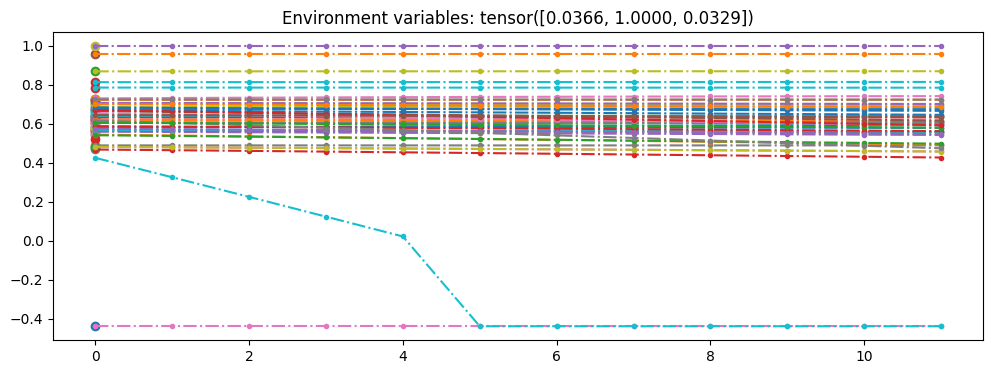

In [51]:
sample = 10000
data0 = torch.tensor(train_dataset[sample]["environ"])
data1 = torch.tensor(train_dataset[sample]["initial_value"])
data2 = torch.tensor(train_dataset[sample]["output"])

print(data0.unsqueeze(1))
env_vec = torch.ones(3,13)*data0.unsqueeze(1)
print(env_vec)
print(data1.shape)
print(data2.shape)
plt.figure(figsize=(12,4))
plt.plot(0, data1.unsqueeze(0), 'o')

N = data2.shape[0]
T = data2.shape[1]
for i in range(N):
    data = data2[i, :]
    plt.plot(torch.arange(T), data, '.-.')

plt.title(f"Environment variables: {data0}")
plt.savefig("data.png", format="png")
plt.show()

## Define the model

In [52]:
# Best model
class Model(nn.Module):
    '''
    Multilayer Perceptron
    '''
    def __init__(self):
        """define network architecuture"""
        super().__init__()  # call the init of super class, python convention
        # Sequential is a contianer that chain its layers in order
        self.layers = nn.Sequential(
            nn.Linear(49, 512),  # input layer to 1st hidden layer
            nn.Linear(512, 1024),  # 1st hidden layer to 2nd hidden layer
            nn.Sigmoid(),  # activation function
            nn.Dropout(p=0.2),
            nn.Linear(1024, 46*12)
        )

    def forward(self, x):
        """Forward pass"""
 
        outputs = self.layers(x)  # inputs pass all layers and get outputs
        outputs = outputs.reshape((-1,46,12))  # reshape to the original output dimension
        return outputs

# Instance a MLP model
model = Model()

# Instance a MLP model
model = Model()


In [53]:
# Define the loss function and optimizer
#loss_function = nn.MSELoss()  # Mean square error
loss_function = nn.HuberLoss(reduction="sum", delta=2)  # Mean square error

# bind the optimiser on the model weights
optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)  # adam optimiser
#optimiser = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.9, weight_decay = 0.00001)  # adam optimiser


# Set device to CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to device
print(device)
model.to(device)  # move model to target device

cuda


Model(
  (layers): Sequential(
    (0): Linear(in_features=49, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=1024, bias=True)
    (2): Sigmoid()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=1024, out_features=552, bias=True)
  )
)

## Train the model

In [54]:
from tqdm import tqdm
# Set fixed random number seed for reproduction
torch.manual_seed(42)

def train(model, print_frequency):
    model.train()
    running_loss = 0.0  # loss of recent batches
    train_loss_epoch = 0.0 
    
    # Iterate over the DataLoader for training data
    for i, batch in enumerate(train_dataloader):

        # Get and prepare inputs
        inputs, targets = prepare_data(batch)
    
        # Perform forward pass and calculate loss
        outputs = model(inputs)
        loss = loss_function(outputs, targets)

        # Zero grad and backpropagation
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        # Print statistics
        running_loss += loss.item()  # accumulate loss of this batch

        if i % print_frequency == print_frequency-1:  # triger print
            # average loss every `print_frequency`
            avg_loss = running_loss / print_frequency
            # uncomment below line to have more messages about training loss
            # print(f"Loss after mini-batch {i+1:5d}: {avg_loss:.9f}")  # print
            train_loss_epoch += running_loss
            running_loss = 0.0  # reset loss accumulator

    train_loss_epoch /= len(train_dataloader)  # average loss of this epoch

    return train_loss_epoch

def valid(model):
    model.eval()
    val_loss_epoch = 0
    with torch.no_grad():
        for i, batch in enumerate(val_dataloader):
            # Get and prepare inputs
            inputs, targets = prepare_data(batch)
            # predict the output with mlp model
            predicts = model(inputs)
            # compute test loss, convert from tensor to float, then accumulate
            val_loss_epoch += loss_function(predicts, targets).item()

    val_loss_epoch /= len(val_dataloader)  # average loss of this epoch
    return val_loss_epoch


# Early stopping parameter
val_patience = 10  # wait how many epochs when validation loss does not decrease
val_count = 0  # number of epochs that validation loss does not decrease
val_loss_min = np.Inf  # current minimal validation loss
early_stopped = False  # whether has reached the best validation loss
best_epoch = 0  # which epoch produced the optimal model

# for log
print_frequency = 100  # log message every x batches

train_losses_epoch = []  # average train loss of each epoch
val_losses_epoch = []  # average validation loss of each epoch

training_start_time = time.time()  # start time of training


# start time of training
training_start_time = time.time()
# Run the training loop
for epoch in range(100): # max epochs

    # set model to train mode, PyTorch convention,
    # because some layers behave differently during training and inferencing
    running_loss = 0.0  # loss of recent batches
    train_loss_epoch = 0.0  # train loss of batches in one epoch
    val_loss_epoch = 0.0  # validation loss of batches in one epoch

    # Train and validate
    train_loss_epoch = train(model, print_frequency)
    val_loss_epoch = valid(model)

    # store loss for each epoch
    train_losses_epoch.append(train_loss_epoch) 
    val_losses_epoch.append(val_loss_epoch)
    
    print(f"Training has been " f"{(time.time()-training_start_time):.0f} seconds")
    print(f"Training loss: {train_loss_epoch}")
    print(f"Validation loss: {val_loss_epoch}")

    
    # early stopping
    # if the validation loss decrease, model after this epoch is better,
    # therefore for store the current model as the 'best' model for now
    if val_loss_epoch < val_loss_min:
      # stop saving model if should be stopped
        if not early_stopped:
            # save model to checkpoint, so you
            torch.save(model.state_dict(), "model.pt")
            
            # update best loss
            val_loss_min = val_loss_epoch 
            
            # reset counter
            val_count = 0  
            
            # record which epoch
            best_epoch = epoch  
            
    else:  # otherwise, we wait a few epochs until no longer decrease
        # increase counter
        val_count += 1 

        # if the validation loss hasn't improved
        if val_count > val_patience:  
            early_stopped = True  # should stop
            print(f"should early stop at epoch {epoch} \n"
                  f"best validation loss is {val_loss_min}")  # print
            break  # early stop, comment out this line to have more epoches


# Process is complete.
print("Training process has finished."  # log
      f"using {(time.time()-training_start_time) / 60:.2f} minutes")


Training has been 5 seconds
Training loss: 235.3112877840937
Validation loss: 16.29847624601224
Training has been 10 seconds
Training loss: 15.71566580071108
Validation loss: 16.266509918939498
Training has been 16 seconds
Training loss: 15.30044809425558
Validation loss: 16.532517726287182
Training has been 21 seconds
Training loss: 15.450962478323252
Validation loss: 16.982621566557782
Training has been 26 seconds
Training loss: 15.532946662461507
Validation loss: 17.86833432020047
Training has been 31 seconds
Training loss: 15.510847828134798
Validation loss: 17.155300458272297
Training has been 36 seconds
Training loss: 15.48784386792738
Validation loss: 16.716633522149287
Training has been 41 seconds
Training loss: 15.507086289765088
Validation loss: 17.23450266024767
Training has been 46 seconds
Training loss: 15.524551390222424
Validation loss: 17.987324681632963
Training has been 52 seconds
Training loss: 15.537579552298082
Validation loss: 18.33693014491688
Training has been 5

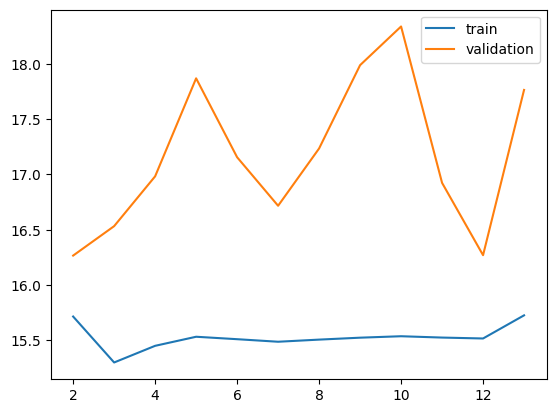

In [55]:
# Training loss
# skip the first epoch since its loss is much larger
# so makes it hard to scale the plot

# plot train loss per epoch
plt.plot(range(2,len(train_losses_epoch)+1), train_losses_epoch[1:], label="train")
# plot validation loss per epoch
plt.plot(range(2,len(train_losses_epoch)+1), val_losses_epoch[1:], label="validation")
plt.legend()  # show the legends
plt.show()  # show plot

In [56]:
import torch.nn.functional as F
import time

# test on testing dataset
DATA_MIN = 0
DATA_MAX = 31.5
ENV_MIN = -20
ENV_MAX = 800

best_model = Model()
best_model.load_state_dict(torch.load("model.pt"))
best_model.to(device)

test_loss = 0  # sum of each testing batch

# set model to evaluation mode, PyTorch convention,
# because some layers behave differently during training and inferencing
best_model.eval()

total_time = 0
# no_grad(): context manager, turn off gradient when evaluating,
# turn on gradient automatically when leaving the `with` block
with torch.no_grad():
    for i, batch in enumerate(test_dataloader):  # for each test batch
        # Get and prepare inputs
        inputs, targets = prepare_data(batch)
        # predict the output with mlp model
        batch_st = time.time()
        predicts = best_model(inputs)
        batch_et = time.time()
        batch_time = batch_et - batch_st
        total_time += batch_time
        # compute test loss, convert from tensor to float, then accumulate
        # test_loss += loss_function(predicts, targets).item()
        # MSE loss
        predicts = predicts * (DATA_MAX - DATA_MIN) + DATA_MIN
        targets = targets * (DATA_MAX - DATA_MIN) + DATA_MIN
        mse_loss = F.mse_loss(predicts, targets)
        # RMSE loss
        rmse_loss = torch.sqrt(mse_loss)
        test_loss += rmse_loss.item()
    # average loss of all batches
    test_loss /= len(test_dataloader)
    total_time /= len(test_dataloader)

print(f"RMSE loss on test dataset is {test_loss}, the running time is {total_time}")  # print the testing loss and running time

RMSE loss on test dataset is 0.9614633373367838, the running time is 0.00015624157794110187


## Best result so far:
RMSE loss on test dataset is 0.08439014229024279, the running time is 0.00015333603168356008, Model2.pt

In [14]:
# Best model
class Model(nn.Module):
    '''
    Multilayer Perceptron
    '''
    def __init__(self):
        """define network architecuture"""
        super().__init__()  # call the init of super class, python convention
        # Sequential is a contianer that chain its layers in order
        self.layers = nn.Sequential(
            nn.Linear(49, 512),  # input layer to 1st hidden layer
            nn.Linear(512, 1024),  # 1st hidden layer to 2nd hidden layer
            nn.Sigmoid(),  # activation function
            nn.Dropout(p=0.2),
            nn.Linear(1024, 46*12)
        )

    def forward(self, x):
        """Forward pass"""
 
        outputs = self.layers(x)  # inputs pass all layers and get outputs
        outputs = outputs.reshape((-1,46,12))  # reshape to the original output dimension
        return outputs

# Instance a MLP model
model = Model()
